<a href="https://colab.research.google.com/github/jrojasquiroz/peru_sno/blob/main/peru_sno.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

En este cuaderno se utiliza el paquete `osmnx` para obtener la orientación de las calles de las ciudades principales del Perú, identificadas por el Instituto Nacional de Estadística e Informática (INEI).

El cálculo se realiza para 91 ciudades, en una primera parte, y luego también para las cinco más pobladas de cada región natural.

**Para publicaciones que utilicen la información obtenida en este cuaderno, por favor cítala de la siguiente manera: "Rojas-Quiroz, J. (2024). Orientación de la red de calles de las principales ciudades del Perú (0.1.0). Zenodo. https://doi.org/10.5281/zenodo.13918305".**

# 1. Pasos previos

In [1]:
import osmnx as ox
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from concurrent.futures import ThreadPoolExecutor

# 2. Primer análisis

En este primer análisis obtenemos los gráficos para todas las grandes ciudades del Perú, identificadas por INEI.

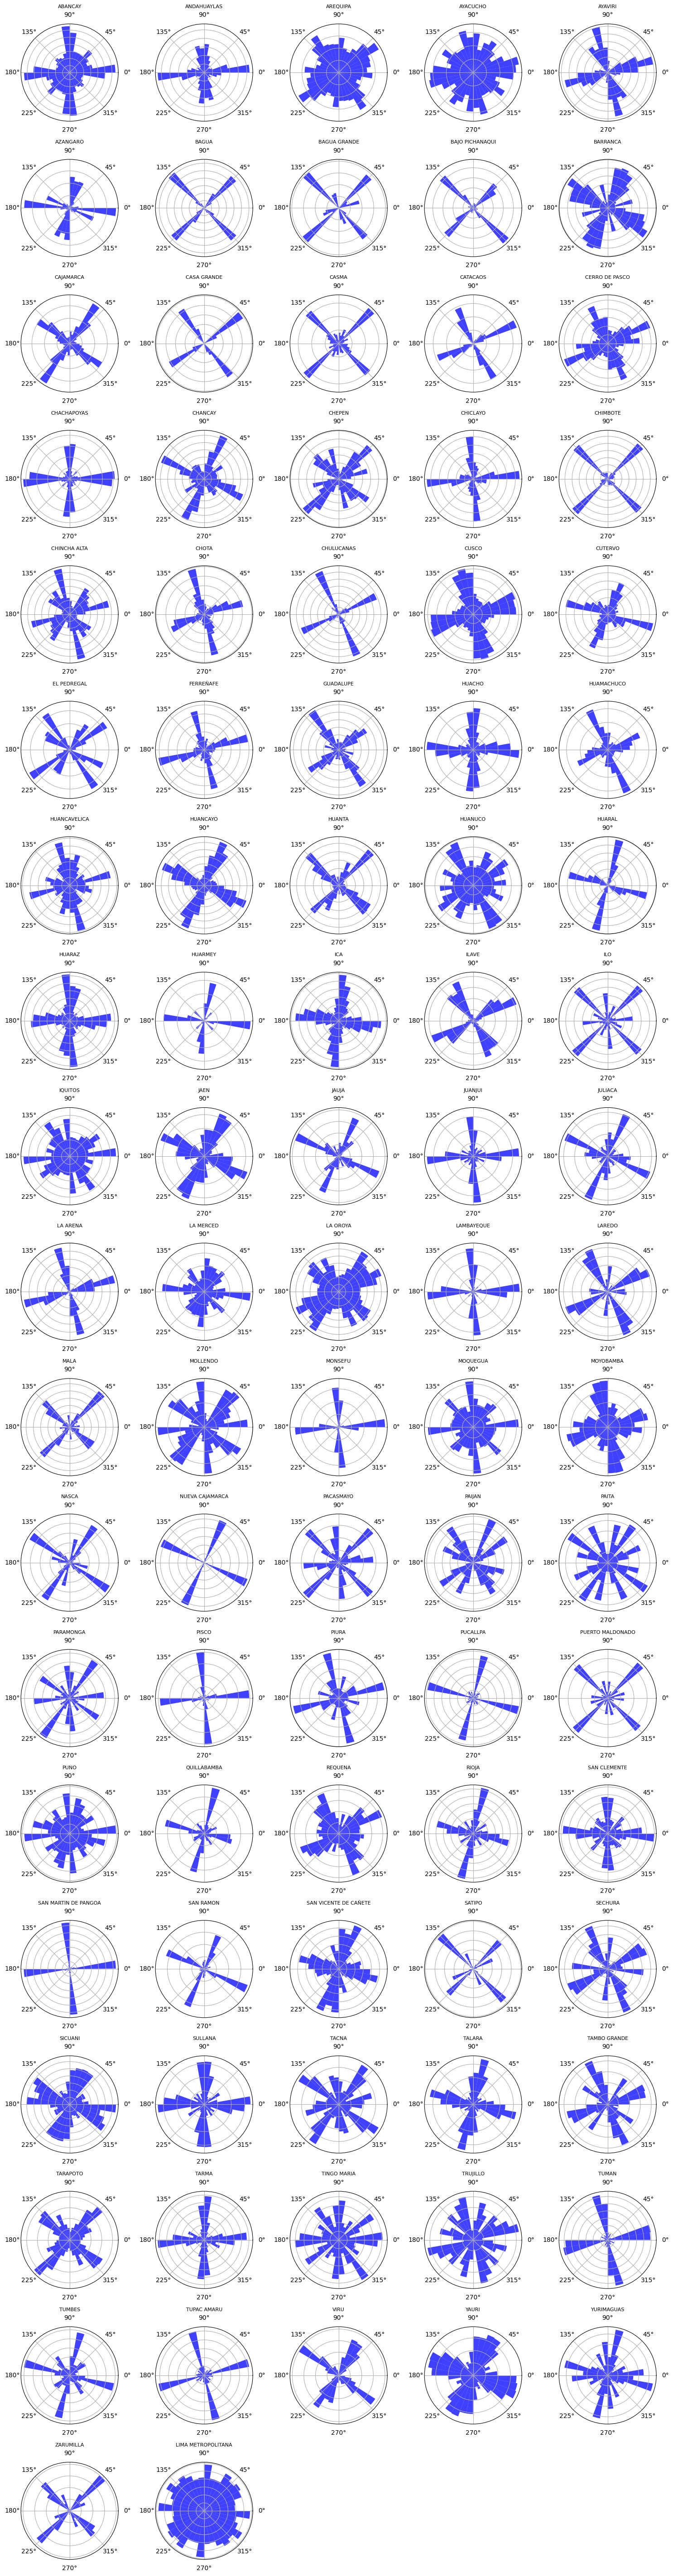

Tiempo de procesamiento: 11 minutos


In [2]:
# Iniciar el temporizador
start_time = time.time()

# Cargar el archivo GeoPackage con las ciudades
gdf_cities = gpd.read_file('../data/pu-principalesciudades-WGS84.gpkg')

# Corregir la geometría de gdf_cities
gdf_cities['geometry'] = gdf_cities['geometry'].buffer(0)  # Aplica buffer(0) para intentar corregir geometrías inválidas
gdf_cities = gdf_cities[gdf_cities.geometry.is_valid]  # Filtra y conserva solo las geometrías válidas

# Configuración de la figura (número de filas y columnas para los subplots)
num_cities = len(gdf_cities)
cols = 5  # Número de columnas en la cuadrícula de gráficos
rows = int(np.ceil(num_cities / cols))  # Calcular el número de filas

# Crear la figura con subplots
fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 3), subplot_kw={'projection': 'polar'})
axes = axes.flatten()  # Aplanar la matriz de ejes para facilitar el acceso

# Función para calcular y graficar la orientación de una ciudad
def plot_city_orientation(city_polygon, ax):
    # Descargar la red de calles dentro del polígono de la ciudad
    graph = ox.graph_from_polygon(city_polygon, network_type='drive')

    # Calcular y agregar los bearings a los bordes del grafo
    graph = ox.bearing.add_edge_bearings(graph)

    # Extraer los bearings (orientaciones de las calles) de los atributos de los bordes
    bearings = [d['bearing'] for u, v, k, d in graph.edges(keys=True, data=True) if 'bearing' in d]

    # Crear el histograma polar
    n, bins, patches = ax.hist(np.deg2rad(bearings), bins=36, color='blue', alpha=0.75)
    ax.set_yticklabels([])  # Remover etiquetas del eje radial
    ax.set_xticks(np.pi / 180.0 * np.linspace(0,  360, 8, endpoint=False))  # 0°, 45°, 90°, etc.

# Iterar sobre las ciudades y sus geometrías
for i, city in gdf_cities.iterrows():
    city_polygon = city['geometry']  # Obtener la geometría (polígono) de la ciudad
    city_name = city['CIUDAD']  # Suponiendo que el nombre de la ciudad está en esta columna

    # Llamar a la función para graficar la orientación
    plot_city_orientation(city_polygon, axes[i])
    axes[i].set_title(city_name, fontsize=8)  # Colocar el nombre de la ciudad como título

# Remover los ejes vacíos si hay menos subplots que la cuadrícula
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Ajustar la figura y mostrar
plt.tight_layout()
plt.savefig('../examples/ciudades_orientacion-inicial.png', dpi=300)  #Selecciona tu propia ruta
plt.show()

# Detener el temporizador
end_time = time.time()
# Calcular el tiempo de procesamiento
execution_time = (end_time - start_time)/60
# Mostrar el tiempo de procesamiento
print(f"Tiempo de procesamiento: {execution_time:.0f} minutos")

# 3. Ciudades más grandes por región

Ahora, seleccionaremos únicamente las cinco más pobladas de la costa, la sierra y la selva.

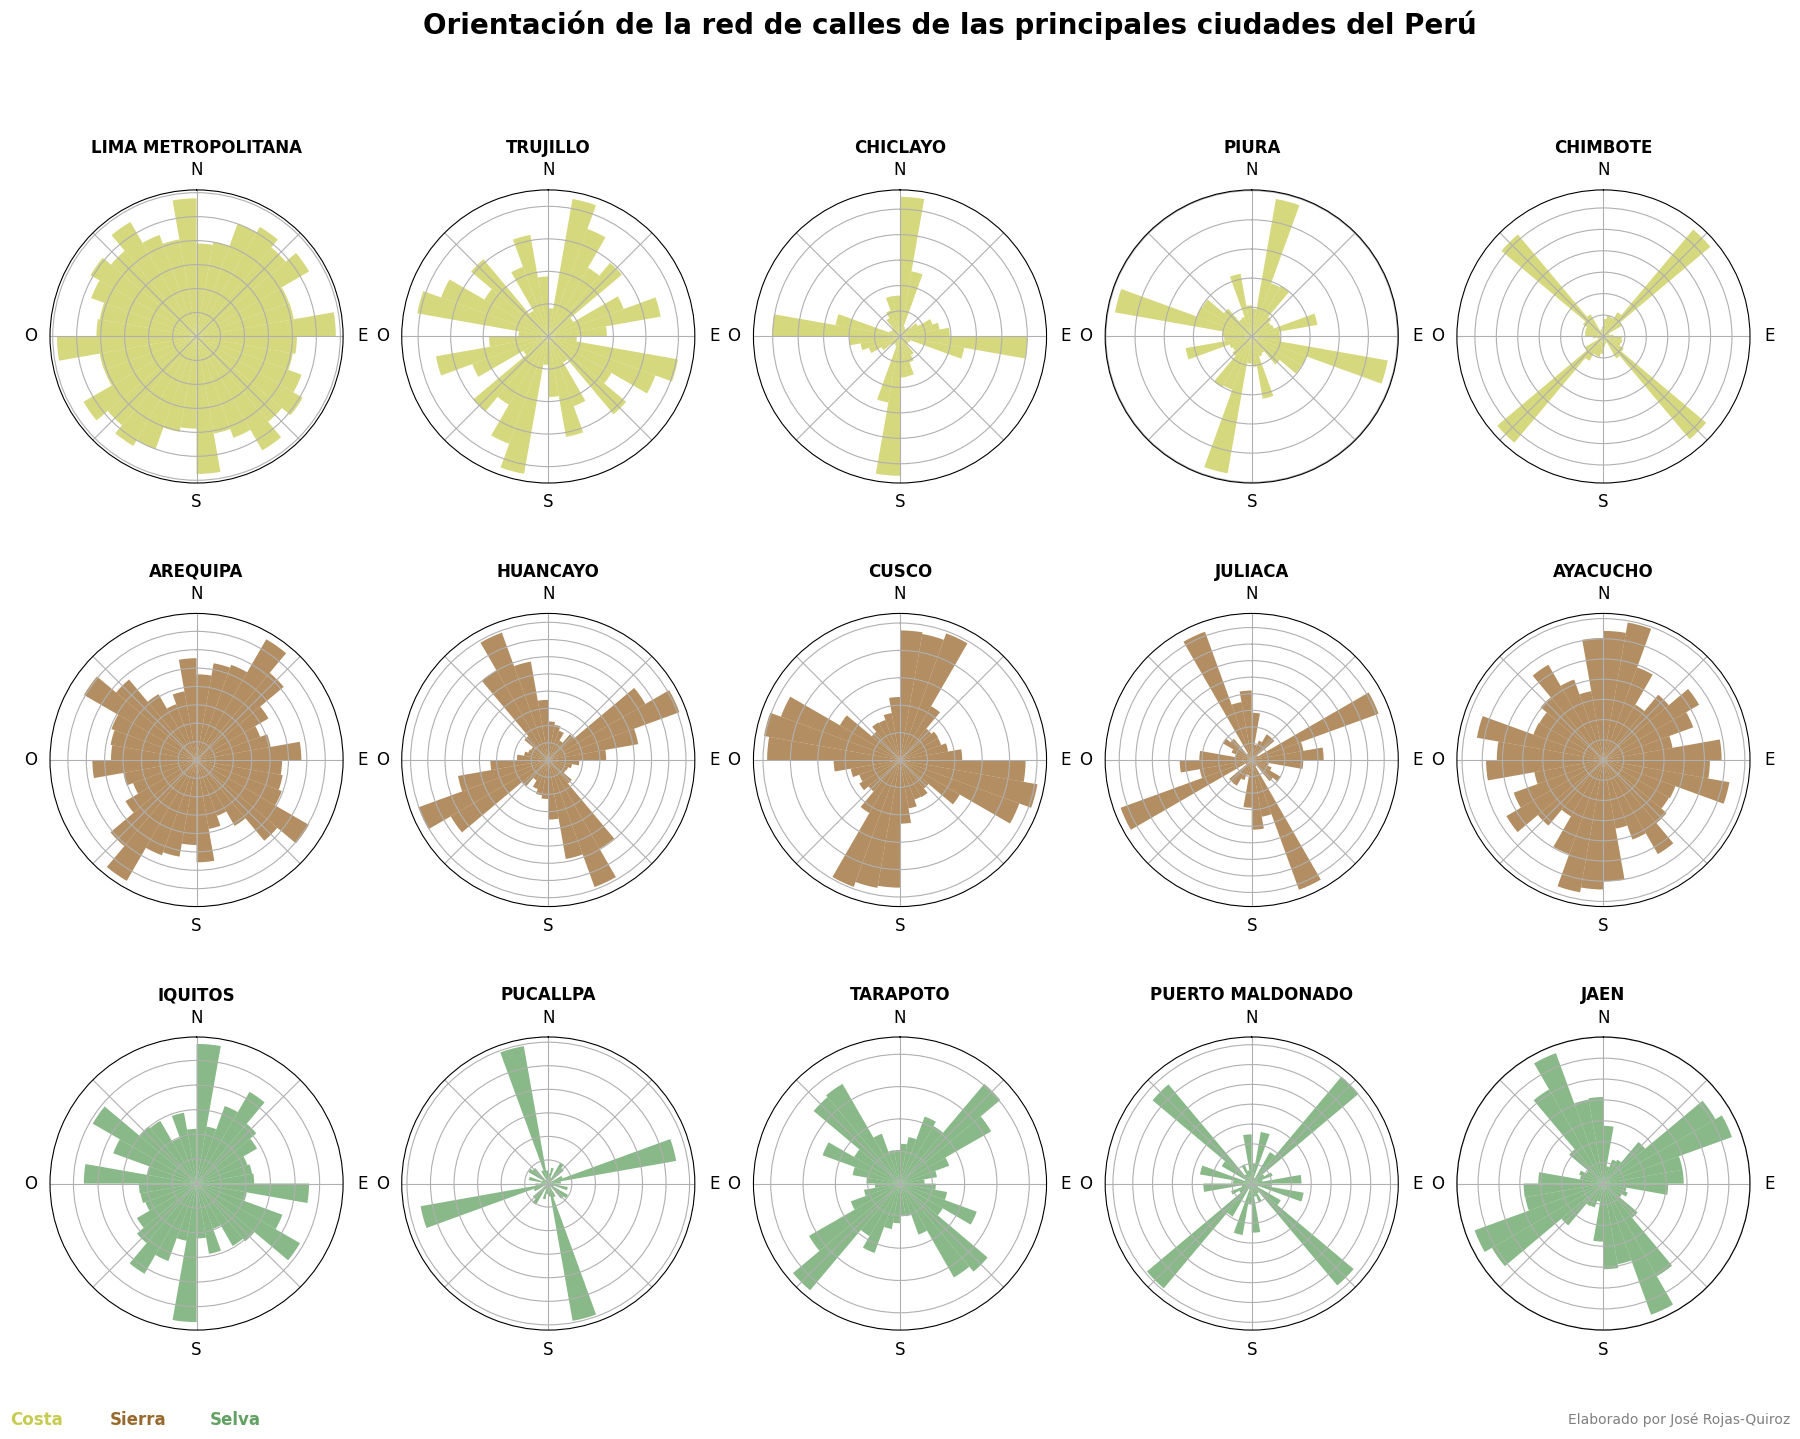

Tiempo de procesamiento: 2 minutos


In [3]:
# Iniciar el temporizador
start_time = time.time()

# Activar el caché de OSMnx para reutilizar datos descargados previamente
ox.settings.use_cache = True

# Función para descargar y procesar la red de calles
def get_bearings(city_polygon):
    try:
        # Descargar la red de calles dentro del polígono de la ciudad
        graph = ox.graph_from_polygon(city_polygon, network_type='drive')
        # Calcular y agregar los bearings a los bordes del grafo
        graph = ox.bearing.add_edge_bearings(graph)
        # Extraer los bearings (orientaciones de las calles) de los atributos de los bordes
        bearings = [d['bearing'] for u, v, k, d in graph.edges(keys=True, data=True) if 'bearing' in d]
        return bearings
    except Exception as e:
        print(f"Error procesando ciudad: {e}")
        return None

# Filtrar por las regiones naturales y ordenar por población ('POB17') para obtener las 5 ciudades más pobladas por región
top_5_costa = gdf_cities[gdf_cities['REGNAT'] == 'Costa'].sort_values(by='POB17', ascending=False).head(5)
top_5_sierra = gdf_cities[gdf_cities['REGNAT'] == 'Sierra'].sort_values(by='POB17', ascending=False).head(5)
top_5_selva = gdf_cities[gdf_cities['REGNAT'] == 'Selva'].sort_values(by='POB17', ascending=False).head(5)

# Unir las 15 ciudades seleccionadas (5 de cada región)
top_cities = gpd.GeoDataFrame(pd.concat([top_5_costa, top_5_sierra, top_5_selva]))

# Configuración de la figura (3 filas y 5 columnas para los subplots)
rows, cols = 3, 5  # 3 filas (una por región) y 5 columnas (5 ciudades por región)
fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 5), subplot_kw={'projection': 'polar'})
axes = axes.flatten()  # Aplanar la matriz de ejes para facilitar el acceso

# Colores para cada región
colores = {
    'Costa': '#c7cb52',
    'Sierra': '#98692e',
    'Selva': '#62a162'
}

# Tipografía
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.size'] = 10

# Direcciones cardinales
direcciones = ['N', '', 'E', '', 'S', '', 'O', '']

# Procesar las redes de calles en paralelo usando ThreadPoolExecutor
with ThreadPoolExecutor(max_workers=5) as executor:
    # Mapear las ciudades a la función para procesar los bearings en paralelo
    results = list(executor.map(get_bearings, top_cities['geometry']))

# Iterar sobre las ciudades, sus geometrías y bearings, asignando el color correcto
for i, (city, bearings) in enumerate(zip(top_cities.iterrows(), results)):
    city_name = city[1]['CIUDAD']  # Obtener el nombre de la ciudad
    region = city[1]['REGNAT']  # Obtener la región natural de la ciudad
    color = colores[region]  # Obtener el color correspondiente a la región

    # Si hay bearings disponibles, graficar la orientación
    if bearings:
        axes[i].hist(np.deg2rad(bearings), bins=36, color=color, alpha=0.75)
        axes[i].set_title(city_name, fontsize=12, fontweight='bold')  # Nombre de la ciudad en negrita
        axes[i].set_yticklabels([])  # Remover etiquetas del eje radial

        # Ajustar etiquetas angulares a solo N, E, S y O
        axes[i].set_xticks(np.pi / 180.0 * np.linspace(0, 360, 8, endpoint=False))  # 0°, 45°, 90°, etc.
        axes[i].set_xticklabels(direcciones, fontsize=12, fontweight='normal')  # Etiquetas en negrita

        # Girar el gráfico para que el Norte esté arriba
        axes[i].set_theta_zero_location('N')
        axes[i].set_theta_direction(-1)  # Hacer que el ángulo aumente en sentido horario

# Ajustar los márgenes para dar más espacio a la parte inferior
plt.subplots_adjust(left=0.05, bottom=0.08)  # Ajustar sólo el margen inferior y un poco a la izquierda

# Añadir la leyenda en la parte inferior de la figura, alineada a la izquierda
fig.text(0.03, 0.04, 'Costa', color=colores['Costa'], fontsize=12, ha='left', va='center', fontweight='bold')
fig.text(0.08, 0.04, 'Sierra', color=colores['Sierra'], fontsize=12, ha='left', va='center', fontweight='bold')
fig.text(0.13, 0.04, 'Selva', color=colores['Selva'], fontsize=12, ha='left', va='center', fontweight='bold')

# Añadir el texto del autor en la parte inferior derecha
fig.text(0.92, 0.04, 'Elaborado por José Rojas-Quiroz', color='gray', fontsize=10, ha='right', va='center')

# Añadir el título del gráfico en la parte superior
fig.suptitle('Orientación de la red de calles de las principales ciudades del Perú', fontsize=20, fontweight='bold')

# Guardar la figura en un archivo con la resolución deseada
plt.savefig('../examples/ciudades_orientacion-principal.png', dpi=300, bbox_inches='tight', pad_inches=0.3)

# Mostrar la figura
plt.show()

# Detener el temporizador
end_time = time.time()
# Calcular el tiempo de procesamiento en segundos
execution_time = (end_time - start_time)/60
# Mostrar el tiempo de procesamiento
print(f"Tiempo de procesamiento: {execution_time:.0f} minutos")